In [1]:
# reload
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import funPlots as fplot

import seaborn as sns

fplot.master_format(ncols = 2, nrows = 2)

In [3]:
from utils.simulation import *
from utils.mutual import (compute_mutual_information_from_trajectories, mutual_information_slowjumps, MC_underhood)
from utils.analytical import *

def get_default_params_system():
    ### Info system
    N = 2
    w = 2
    k = 1.1
    tau_ei = 1
    r = np.ones(N)
    
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r}

In [4]:
data_folder = 'data/'

inputs_slow = np.load(data_folder+'inputs_slow.npy')
states_slow = np.load(data_folder+'states_slow.npy')

inputs_fast = np.load(data_folder+'inputs_fast.npy')
states_fast = np.load(data_folder+'states_fast.npy')


### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info simulation
steps = int(5e6)
dt = 0.005

### Create info dictionary
info_system = create_info_system(**get_default_params_system())
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(steps,dt)

In [5]:
idx_start = 175000
idx_end = 255000

Nsteps = idx_end - idx_start

Time = np.arange(Nsteps)*dt

In [6]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info system - increase w
info_system['w'] = 5 # was 40

### Simulation params
taus = np.logspace(-1,3,10)
bins = 100

### Info simulation
steps = int(1e7)
dt = 0.01

### Compute bounds
upper_bound = theo_ub(info_system['w'], info_system['k'], p_stat, info_input['hs'])
lower_bound = theo_lb(info_system['w'], info_system['k'], p_stat, info_input['hs'])

ress = np.load(data_folder+'mutual_different_timescales.npy')

print(lower_bound, upper_bound)

0.8141237158419327 1.037052357929819


In [7]:
colors = ("#76c893", "#184e77")
labels = ('$E$', '$I$')

In [8]:
t_min = 10000
h_fast, bins_fast_x, bins_fast_y = np.histogram2d(states_fast[t_min:,0], states_fast[t_min:,1],
                                                  bins = 100, density=True)
h_slow, bins_slow_x, bins_slow_y = np.histogram2d(states_slow[t_min:,0], states_slow[t_min:,1],
                                                  bins = 100, density=True)

h_max = max(h_fast.max(), h_slow.max())

/Users/giorgionicoletti/miniconda3/envs/minpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giorgionicoletti/miniconda3/envs/minpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giorgionicoletti/miniconda3/envs/minpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giorgionicoletti/miniconda3/envs/minpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

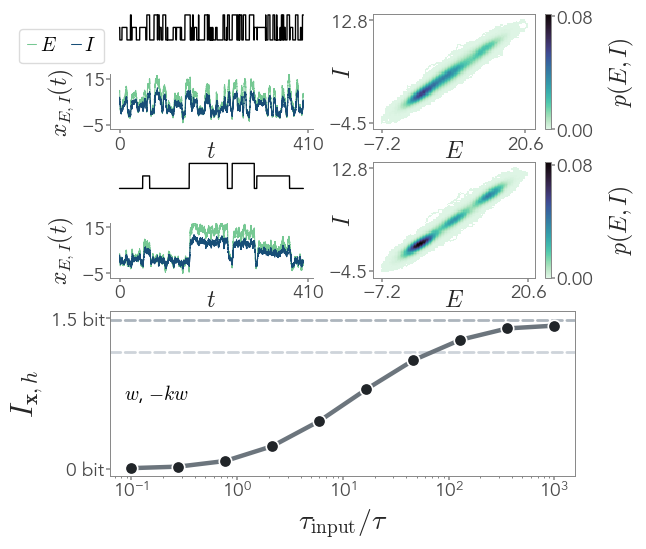

In [12]:
fig, axs = plt.subplot_mosaic([["hf", "pf"],
                               ["tf", "pf"],
                               ["hs", "ps"],
                               ["ts", "ps"],
                               ["i", "i"]], figsize = (6, 6),
                               gridspec_kw = {'height_ratios': [0.5, 1, 0.5, 1, 3]})

plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

for ax in [axs["tf"], axs["ts"]]:
    ax.spines[['top','right']].set_visible(False)
    ax.set_xticks([0, 410])
    ax.set_yticks([-5, 15])
    ax.set_xlabel('$t$', labelpad = -10)
    ax.set_ylabel('$x_{E, I}(t)$')
    ax.set_ylim(-7, 17)


for ax in [axs["hf"], axs["hs"]]:
    ax.axis('off')

axs["hf"].plot(Time, hs[0][inputs_fast][idx_start:idx_end], c = 'k', lw = 1)
axs["hs"].plot(Time, hs[0][inputs_slow][idx_start:idx_end], c = 'k', lw = 1)

for idx, state in enumerate(states_fast.T):
    axs["tf"].plot(Time, state[idx_start:idx_end], label=labels[idx],
                   c=colors[idx], lw = 0.75)

axs["tf"].legend(ncols = 2, bbox_to_anchor = (-0.5,2), loc = "upper left", fontsize = 14, handlelength = 0.5,
                 handletextpad = 0.2, columnspacing = 0.7)

for idx, state in enumerate(states_slow.T):
    axs["ts"].plot(Time, state[idx_start:idx_end], label=labels[idx],
                   c=colors[idx], lw = 0.75)
    
sns.histplot(x=states_fast[t_min:,0], y=states_fast[t_min:,1], bins=100, ax=axs["pf"],
             cmap='mako_r', stat='density', cbar=True, vmin = 0, vmax = h_max,
             rasterized = True)

sns.histplot(x=states_slow[t_min:,0], y=states_slow[t_min:,1], bins=100, ax=axs["ps"],
                cmap='mako_r', stat='density', cbar=True, vmin = 0, vmax = h_max,
                rasterized = True)

for ax in [axs["pf"], axs["ps"]]:
    ax.set_xlabel(labels[0], labelpad = -10)
    ax.set_ylabel(labels[1], labelpad = -20)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, np.round(h_max, 2)])
    cbar.set_label(r'$p(E, I)$', labelpad = 10)

    ax.set_xticks([-7.2, 20.6])
    ax.set_yticks([-4.5, 12.8])

axs["i"].set_xscale('log')

axs["i"].scatter(taus / info_system['tau_ei'], ress, c = '#212529', s = 80, ec = "w", lw = 1.2)
axs["i"].plot(taus / info_system['tau_ei'], ress, c = '#6c757d', lw = 3.2, zorder = -10, alpha = 1)

axs["i"].axhline(upper_bound, c="#adb5bd", ls='--', lw=2,
                 label=r'$I_{up}$', zorder = -np.inf)
axs["i"].axhline(lower_bound, c="#ced4da", ls='--', lw=2,
                 label=r'$I_{down}$', zorder = -np.inf)

axs["i"].set_xlabel(r'$\tau_\mathrm{input} / \tau$', fontsize = 20)
axs["i"].set_ylabel(r'$I_{\mathbf{x},h}$', fontsize = 22)

axs["i"].set_ylim(-0.05, 1.1)

axs["i"].set_yticks([0,1.05])
axs["i"].set_yticklabels(["0 bit", f"{np.round(1.05/np.log(2), 1)} bit"])

axs["i"].text(0.1,0.5,"$w$, $-kw$", transform = axs["i"].transAxes, fontsize = 14, ha = 'center', va = 'center')

plt.savefig('figures/Figure1_draft.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [303]:
1/np.log(2)

1.4426950408889634